<a href="https://colab.research.google.com/github/GDharan10/Project8_ClassificationModelForFinancialStatements/blob/main/Classification_Model_For_Financial_Statementsipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
pip install lazypredict

# **Libraries**

In [34]:
import os
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,\
ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import pickle

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Function to clean text
def clean_text(text):
    # Remove non-alphanumeric characters, except spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove lowercase letters if they appear separately
    text = re.sub(r'\b[a-z]\b', '', text)
    # Remove uppercase letters if they appear separately
    text = re.sub(r'\b[A-Z]\b', '', text)
    # Remove Roman numerals
    roman_numerals = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'IX', 'X', 'XIII', 'XIV', 'XV', 'XVI', 'XVII',
                      'XVIII', 'XIX', 'XX', 'XXI', 'XXII', 'XXIII', 'XXIV', 'XXV', 'XXVI', 'i', 'ii', 'iii',
                      'iv', 'v', 'vi']
    for numeral in roman_numerals:
        text = re.sub(r'\b{}\b'.format(numeral), '', text)
    # Remove extra spaces
    cleaned_text = re.sub(r'\s+', ' ', text)
    return cleaned_text.strip()

In [17]:
# Function to collect data from html file folders
def process_html_files(folder_paths, document_names):
    # Initialize an empty list to store DataFrames
    dfs_list = []

    for folder_path, doc_name in zip(folder_paths, document_names):
        # Process each HTML file in the folder
        for filename in os.listdir(folder_path):
            if filename.endswith(".html"):
                file_path = os.path.join(folder_path, filename)
                # Read HTML tables into a list of DataFrame objects
                dfs = pd.read_html(file_path)
                # Assuming the desired table is the first one
                table_df = dfs[0]
                # Extract text from the first two columns of the first table
                extracted_text = ' '.join(str(cell) for cell in table_df.iloc[:, :2].values.flatten() if pd.notnull(cell))
                # Clean the extracted text
                cleaned_text = clean_text(extracted_text)
                # Create a DataFrame with cleaned text and document name
                df = pd.DataFrame({'Extracted_text': [cleaned_text], 'document_name': doc_name})
                # Append the DataFrame to the list
                dfs_list.append(df)

    # Concatenate all DataFrames in the list into a single DataFrame
    final_df = pd.concat(dfs_list, ignore_index=True)
    return final_df


In [39]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')
# Stop words and stemmer
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()
# Function for Tokenization, stop words removal and stemming
def preprocess_text(text):
    words = word_tokenize(text)
    words = [ps.stem(word) for word in words if word.lower() not in stop_words]
    return ' '.join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **Data collection**

In [18]:
# Folder paths and document names
folder_paths = [
    "/content/drive/MyDrive/Task/FinacPlus/data/data/Balance Sheets",
    "/content/drive/MyDrive/Task/FinacPlus/data/data/Cash Flow",
    "/content/drive/MyDrive/Task/FinacPlus/data/data/Income Statement",
    "/content/drive/MyDrive/Task/FinacPlus/data/data/Notes",
    "/content/drive/MyDrive/Task/FinacPlus/data/data/Others"
]

document_names = ["Balance Sheets", "Cash Flow", "Income Statement", "Notes", "Others"]

In [19]:
# Process the HTML files and get the final DataFrame
df = process_html_files(folder_paths, document_names)

# Display the final DataFrame
df

,Extracted_text,document_name
0,SI Particulars No No ASSETS NonCurrent Assets ...,Balance Sheets
1,STANDALONE March Particulars Audited ASSETS No...,Balance Sheets
2,GRINDWELL NORTON LIMITED Statement of Standalo...,Balance Sheets
3,ASSETS NonCurrent Assets Property Plant and Eq...,Balance Sheets
4,SIGNED FOR IDENTIFICATIO CD CD SRBCCO LLP SRBC...,Balance Sheets
...,...,...
2520,Exceptional Items continuing operations Amount...,Others
2521,Particulars Quarter ended Particulars Revenue ...,Others
2522,yL Firms Registration Number Rajiv Singhi Part...,Others
2523,Symbol Typeof security BSE Equity NSE GRINDWELL,Others


# **EDA (Exploratory Data Analysis)**

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2525 entries, 0 to 2524
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Extracted_text  2525 non-null   object
 1   document_name   2525 non-null   object
dtypes: object(2)
memory usage: 39.6+ KB


In [21]:
df.describe().T

,count,unique,top,freq
Extracted_text,2525,2412,,27
document_name,2525,5,Others,1224


In [22]:
df.isnull().sum()

Extracted_text    0
document_name     0
dtype: int64

In [23]:
df.duplicated().sum()

110

In [24]:
df.document_name.value_counts()

document_name
Others              1224
Notes                690
Income Statement     305
Balance Sheets       270
Cash Flow             36
Name: count, dtype: int64

# **Data_Preprocessing**

In [25]:
df.drop_duplicates(inplace = True)

In [26]:
df.columns

Index(['Extracted_text', 'document_name'], dtype='object')

In [27]:
df.document_name.value_counts()

document_name
Others              1138
Notes                668
Income Statement     305
Balance Sheets       268
Cash Flow             36
Name: count, dtype: int64

In [28]:
# Apply the cleaning function to the Extracted_text column
df['Extracted_text'] = df['Extracted_text'].apply(clean_text)

In [ ]:
# Tokenization, stop words removal and stemming
df['Extracted_text'] = df['Extracted_text'].apply(preprocess_text)

In [49]:
# Vectorization the text
tfidf = TfidfVectorizer(max_features=150)
vectorization = tfidf.fit(df['Extracted_text'])
X = vectorization.transform(df['Extracted_text']).toarray()

# Encode the target variable
label_encoder = LabelEncoder()
label_encoder.fit(df['document_name'])
Y = label_encoder.transform(df['document_name'])

# **Machine Learning**

In [32]:
# Splitting the data for training and testing sets
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25, random_state=42)

In [ ]:
#Model Selection and Training
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(x_train, x_test, y_train, y_test)
print(models)

 97%|█████████▋| 28/29 [00:22<00:01,  1.48s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11013
[LightGBM] [Info] Number of data points in the train set: 1811, number of used features: 150
[LightGBM] [Info] Start training from score -2.198330
[LightGBM] [Info] Start training from score -4.457112
[LightGBM] [Info] Start training from score -2.089988
[LightGBM] [Info] Start training from score -1.263310
[LightGBM] [Info] Start training from score -0.752875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

100%|██████████| 29/29 [00:24<00:00,  1.18it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model               

In [ ]:
from lightgbm import LGBMClassifier
LGB_model=LGBMClassifier().fit(x_train,y_train)
y_pred_train = LGB_model.predict(x_train)
y_pred_test = LGB_model.predict(x_test)

accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10837
[LightGBM] [Info] Number of data points in the train set: 1811, number of used features: 150
[LightGBM] [Info] Start training from score -2.198330
[LightGBM] [Info] Start training from score -4.457112
[LightGBM] [Info] Start training from score -2.089988
[LightGBM] [Info] Start training from score -1.263310
[LightGBM] [Info] Start training from score -0.752875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

(0.9939260077305356, 0.9205298013245033)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
ETC_model=ExtraTreesClassifier().fit(x_train,y_train)
y_pred_train = ETC_model.predict(x_train)
y_pred_test = ETC_model.predict(x_test)

accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)

(0.9939260077305356, 0.9288079470198676)

In [33]:
from sklearn.svm import SVC
SVC_model=SVC().fit(x_train,y_train)
y_pred_train = SVC_model.predict(x_train)
y_pred_test = SVC_model.predict(x_test)

accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)

(0.9685256764218664, 0.9205298013245033)

# **Saving modules**

In [50]:
pickle_=open("Vectorization_model","wb")
pickle.dump(vectorization,pickle_)
pickle_.close()

In [36]:
pickle_=open("ClassifyingFinancialStatements_model","wb")
pickle.dump(label_encoder,pickle_)
pickle_.close()

In [35]:
pickle_=open("Financial_Statements_model","wb")
pickle.dump(SVC_model,pickle_)
pickle_.close()

# **Evaluation**

Accuracy: 0.9238410596026491
precision_score: 0.9439563082253202
recall_score: 0.9432636189274053
confusion_matrix: [[ 65   0   1   0   1]
 [  0  15   0   0   0]
 [  0   0  75   1   5]
 [  1   0   0 140  15]
 [  1   0   4  17 263]]


AttributeError: 'function' object has no attribute 'shape'

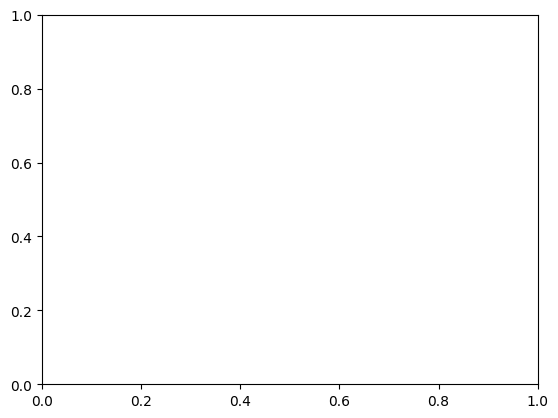

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("precision_score:", precision_score(y_test, y_pred_test, average='macro'))
print("recall_score:", recall_score(y_test, y_pred_test, average='macro'))
print("confusion_matrix:", confusion_matrix(y_test, y_pred_test))
disp = ConfusionMatrixDisplay(confusion_matrix)
disp.plot()
plt.show()
print("Classification Report:\n", classification_report(y_test, y_pred_test))

In [ ]:
from sklearn.model_selection import cross_val_score

# Cross-validation
cv_scores = cross_val_score(SVC_model, x_train, y_train, cv=5)

print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())


Cross-validation scores: [0.89807163 0.92265193 0.90331492 0.91160221 0.90055249]
Mean cross-validation score: 0.9072386344611356


# **Test new documents**

In [51]:
# Load the TfidfVectorizer
pickel_in=open("/content/Vectorization_model","rb")
vectorization=pickle.load(pickel_in)

# Load the encoder
pickel_in=open("/content/ClassifyingFinancialStatements_model","rb")
encoder=pickle.load(pickel_in)

# Load the pre-trained model
pickel_in=open("/content/Financial_Statements_model","rb")
model=pickle.load(pickel_in)

In [ ]:
# Function to process HTML file, vectorize, predict, and decode
def process_vectorize_predict_and_decode(file_path):
    # Read HTML tables into a list of DataFrame objects
    dfs = pd.read_html(file_path)
    # Assuming the desired table is the first one
    table_df = dfs[0]
    # Extract text from the first two columns of the first table
    extracted_text = ' '.join(str(cell) for cell in table_df.iloc[:, :2].values.flatten() if pd.notnull(cell))
    # Clean the extracted text
    cleaned_text = clean_text(extracted_text)
    # Create a DataFrame with the extracted text
    final_df = pd.DataFrame({'Extracted_text': [cleaned_text]})
    # Preprocess the text
    final_df['Processed_text'] = final_df['Extracted_text'].apply(preprocess_text)
    # Vectorize the text
    X = vectorization.transform(final_df['Processed_text']).toarray()
    # Use the model to predict
    predictions = model.predict(X)
    # Decode the predictions
    decoded_predictions = encoder.inverse_transform(predictions)
    return decoded_predictions

In [ ]:
# Example usage
file_path = "/content/drive/MyDrive/Task/FinacPlus/data/data/Balance Sheets/18320959_3.html"

# Process the HTML file, vectorize, get the predictions, and decode
decoded_predictions = process_vectorize_predict_and_decode(file_path)

# Display the decoded predictions
print(decoded_predictions)

# end